In [1]:
# Import related libraries

import numpy as np # linear algebra 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

%matplotlib notebook  
import matplotlib as mpl
import skimage
import numpy as np
import os

from IPython.display import Image
from ipywidgets import interact, interactive, fixed

from skimage import data, filters, io, img_as_float

from io import BytesIO

In [2]:
# Read data

train_data = pd.read_csv('input/index.csv')
test_data = pd.read_csv('input/test.csv')
submission = pd.read_csv('input/sample_submission.csv')

In [3]:
# View data shape
print("Training data size",train_data.shape)
print("test data size",test_data.shape)

Training data size (1098461, 2)
test data size (117703, 2)


In [4]:
# View first 5 records of train data
train_data.head()

,id,url
0,b09ea096f4daa42e,https://lh5.googleusercontent.com/-wBt6sklzbGs...
1,6648383c7b3a438c,https://lh3.googleusercontent.com/-OADWsOZq83E...
2,d485d9f770e40453,https://lh5.googleusercontent.com/-vtZFUTuFWGM...
3,e7cdfba9ec7e9dd5,https://lh4.googleusercontent.com/-Skq6Q-VUALk...
4,44806beb654e6410,https://lh4.googleusercontent.com/-6eIkjkr3j2w...


In [5]:
# Vuew first 5 records of test data
test_data.head()

,id,url
0,000088da12d664db,https://lh3.googleusercontent.com/-k45wfamuhT8...
1,0001623c6d808702,https://lh3.googleusercontent.com/-OQ0ywv8KVIA...
2,0001bbb682d45002,https://lh3.googleusercontent.com/-kloLenz1xZk...
3,0002362830cfe3a3,https://lh3.googleusercontent.com/-N6z79jNZYTg...
4,000270c9100de789,https://lh3.googleusercontent.com/-keriHaVOq1U...


In [6]:
# View first 5 records of submission data

submission.head()

,id,images
0,000088da12d664db,0370c4c856f096e8 766677ab964f4311 e3ae4dcee813...
1,0001623c6d808702,b01175326ee19742 67eb4fc9ff184bd2 0f775e72c031...
2,0001bbb682d45002,5101d06f891261be ae9c548dcf7102e2 a42098eb2dd3...
3,0002362830cfe3a3,40cb31b754bb7249 f860d7fbb0073fab 492c16c0584d...
4,000270c9100de789,fe3a62d9b50ca221 5005114ed61af1bc 754e137d888d...


In [7]:
# missing data in training data 
total = train_data.isnull().sum().sort_values(ascending = False)
percent = (train_data.isnull().sum()/train_data.isnull().count()).sort_values(ascending = False)
missing_train_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_train_data.head()

,Total,Percent
url,0,0.0
id,0,0.0


In [8]:
# missing data in test data 
total = test_data.isnull().sum().sort_values(ascending = False)
percent = (test_data.isnull().sum()/test_data.isnull().count()).sort_values(ascending = False)
missing_test_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_test_data.head()

,Total,Percent
url,0,0.0
id,0,0.0


## As we can see there is no missing data for either of the dataset. So we can say that its really very clean dataset. So lets do some data visualization and see the findings

In [9]:
from IPython.display import Image
from IPython.core.display import HTML 

def display_category(urls, category_name):
    img_style = "width: 180px; margin: 0px; float: left; border: 1px solid black;"
    images_list = ''.join([f"<img style='{img_style}' src='{u}' />" for _, u in urls.head(20).iteritems()])

    display(HTML(images_list))

In [10]:
urls = train_data['url']
display_category(urls, "")

In [11]:
import matplotlib.pyplot as plt
import sys
import io
import os
import csv
import tensorflow as tf
from time import time 
from urllib import request, error
from PIL import Image
from io import BytesIO
from IPython import display
import datetime

In [12]:
def parse_data(data_file):
    csvfile = open(data_file, 'r')
    csvreader = csv.reader(csvfile)
    key_url_list = [line[:2] for line in csvreader]
    return key_url_list[1:]  # Chop off header

In [13]:
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [14]:
def write_example(writer, pil_image, key, url):
    example = tf.train.Example(features=tf.train.Features(feature={
            #'height': _int64_feature(pil_image.size[1]),
            #'width': _int64_feature(pil_image.size[0]),
            'key': _bytes_feature(str.encode(key)),
            'url': _bytes_feature(str.encode(url)),
            'img_raw':_bytes_feature(pil_image)
        }))
    writer.write(example.SerializeToString())

In [15]:
input_folder = "input"
output_folder = "output"

In [16]:
input_folder = "input"
output_folder = "output"

In [17]:
data_file = os.path.join(input_folder, "index.csv")
key_url_list = parse_data(data_file)

In [18]:
opts = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.ZLIB)

tfrecords_filename = os.path.join(output_folder, 'img_{}.tfrecords')

In [19]:
start_time = time()

skipped = open(os.path.join(output_folder,'skipped.csv'),'w')
downloaded = open(os.path.join(output_folder, 'downloaded.csv'),'w')
counters = {}
counters['skipped'] = 0
counters['attempts'] = 0
writer = tf.python_io.TFRecordWriter(tfrecords_filename.format(counters['attempts']), options=opts)
total = len(key_url_list)
print("starting download")
for x in key_url_list:
    key = x[0]
    url = x[1]
    is_skipped = False
    image_data = None
    if counters['attempts'] % 1000 == 0:
        if writer:
            writer.close()      
        writer = tf.python_io.TFRecordWriter(tfrecords_filename.format(counters['attempts']), options=opts)
        downloaded.flush()
        skipped.flush()
    
    try:
        counters['attempts'] += 1
        response = request.urlopen(url)
        image_data = response.read()
        display.clear_output(wait=True)
        print("{:5}% | attempts: {:7} | skipped: {:7} | elapsed: {:8} | {:4} it/s".format(
                  round(counters['attempts']/total,2)
                , counters['attempts']
                , counters['skipped']
                , str(datetime.timedelta(seconds=round(time()-start_time,2))).split('.', 2)[0]
                , round(counters['attempts']/(time()-start_time),2)
            ))
    except:
        skipped.write('"{}","{}"\n'.format(key, url))
        counters['skipped'] += 1
        is_skipped = True
    
    if not is_skipped:
        downloaded.write('"{}","{}"\n'.format(key, url))
        write_example(writer, image_data, key, url)

    if counters['attempts']>1:
        break

if downloaded:
    downloaded.close()
if skipped:
    skipped.close()
if writer:
    writer.close()  

  0.0% | attempts:       2 | skipped:       0 | elapsed: 0:00:04  | 0.43 it/s


In [20]:
record_iterator = tf.python_io.tf_record_iterator(path=tfrecords_filename.format(0), options=opts)

img_string = ""
i=0
for string_record in record_iterator:
    
    example = tf.train.Example()
    example.ParseFromString(string_record)
                
    img_string = (example.features.feature['img_raw'].bytes_list.value[0])
    
    key = (example.features.feature['key']
                                .bytes_list
                                .value[0])
    
    url = (example.features.feature['url']
                                .bytes_list
                                .value[0])
    
    img = tf.image.decode_jpeg(example.features.feature['img_raw'].bytes_list.value[0], channels=3)
    img.set_shape([180,180,3])
    img = tf.image.convert_image_dtype(img, tf.float32)
    print(key, url)
    #print(height, width)
    i = i + 1
    if i > 2:
        break   

b'b09ea096f4daa42e' b'https://lh5.googleusercontent.com/-wBt6sklzbGs/SZGP_M9fmVI/AAAAAAAAAI8/CPeKaQtSpwA/s1600/'
b'6648383c7b3a438c' b'https://lh3.googleusercontent.com/-OADWsOZq83E/ScwYRY2RCDI/AAAAAAAABjE/EiocQv4Brec/s1600/'


In [21]:
with tf.Session() as sess:
    img_s = sess.run(img)

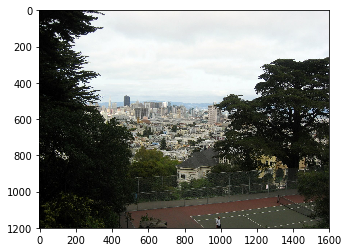

In [22]:
plt.imshow(img_s)

## download images - this script run it in local machine with passing two arguments index file and output directory

In [ ]:
#!/usr/bin/env python

# Note: requires the tqdm package (pip install tqdm)

# Note to Kagglers: This script will not run directly in Kaggle kernels. You
# need to download it and run it on your local machine.

# Downloads images from the Google Landmarks dataset using multiple threads.
# Images that already exist will not be downloaded again, so the script can
# resume a partially completed download. All images will be saved in the JPG
# format with 90% compression quality.

# Thanks to @maxwell: https://www.kaggle.com/maxwell110/python3-version-image-downloader

import sys, os, multiprocessing, csv
from urllib import request, error
from PIL import Image
from io import BytesIO
import tqdm


def parse_data(data_file):
    csvfile = open(data_file, 'r')
    csvreader = csv.reader(csvfile)
    key_url_list = [line[:2] for line in csvreader]
    return key_url_list[1:]  # Chop off header


def download_image(key_url, img_dims=(256,256)):
    out_dir = sys.argv[2]
    (key, url) = key_url
    filename = os.path.join(out_dir, '{}.jpg'.format(key))

    if os.path.exists(filename):
        print('Image {} already exists. Skipping download.'.format(filename))
        return 0

    try:
        response = request.urlopen(url)
        image_data = response.read()
    except:
        print('Warning: Could not download image {} from {}'.format(key, url))
        return 1

    try:
        pil_image = Image.open(BytesIO(image_data))
    except:
        print('Warning: Failed to parse image {}'.format(key))
        return 1

    try:
        pil_image_rgb = pil_image.convert('RGB')
    except:
        print('Warning: Failed to convert image {} to RGB'.format(key))
        return 1
        
    try:
        pil_image_rgb.thumbnail(img_dims)
    except:
        print("Warning: Failed to resize image {}".format(key))
        return 1

    try:
        pil_image_rgb.save(filename, format='JPEG', quality=90)
    except:
        print('Warning: Failed to save image {}'.format(filename))
        return 1
    
    return 0


def loader():
    if len(sys.argv) != 3:
        print('Syntax: {} <data_file.csv> <output_dir/>'.format(sys.argv[0]))
        sys.exit(0)
    (data_file, out_dir) = sys.argv[1:]

    if not os.path.exists(out_dir):
        os.mkdir(out_dir)

    key_url_list = parse_data(data_file)
    pool = multiprocessing.Pool(processes=20)  # Num of CPUs
    failures = sum(tqdm.tqdm(pool.imap_unordered(download_image, key_url_list), total=len(key_url_list)))
    print('Total number of download failures:', failures)
    pool.close()
    pool.terminate()


# arg1 : data_file.csv
# arg2 : output_dir
if __name__ == '__main__':
    loader()
    